1. Demuestre la siguiente identidad de acuerdo a las definiciones vistas en la clase 1, demuestre.

$$
rms(x)^2 = avg(x)^2 + stf(x)^2
$$

Sea x $\in \mathbb{R}^n$. \
Como:

$$rms(x) = \sqrt(\frac{x^2_1 + ... + x^2_n}{n}) = \frac{||x||}{\sqrt(n)}$$

$$std(x) = rms(x - avg(x)\textbf{1}) = \frac{1}{\sqrt(n)}\sqrt(\sum\limits_{i=1}^n(x_i - avg(x))^2)$$



Entonces:

$$
rms(x)^2 = avg(x)^2 + stf(x)^2
$$

$$
rms(x)^2 = avg(x)^2 + \frac{1}{n}\sum\limits_{i=1}^n(x_i - avg(x))^2
$$

$$
rms(x)^2 = avg(x)^2 + 
\frac{1}{n}\sum\limits_{i=1}^n(
    x_i^2 - 2avg(x)x_i + avg(x)^2
)
$$

$$
rms(x)^2 = avg(x)^2 + 
\frac{1}{n}\sum\limits_{i=1}^n x_i^2 

- \frac{1}{n}\sum\limits_{i=1}^n 2 avg(x) x_i 

+ \frac{1}{n}\sum\limits_{i=1}^n avg(x)^2
$$

Como avg(x) es una constante, entonces:

$$
rms(x)^2 = avg(x)^2 + 
\frac{1}{n}\sum\limits_{i=1}^n x_i^2 

- \frac{2avg(x)}{n}\sum\limits_{i=1}^n  x_i 

+ \frac{avg(x)^2 \cancel{n}}{\cancel{n}} 
$$

Luego, como:

$$avg(x) = \frac{1}{n} \sum\limits_{i=1}^nx_i$$

Entonces:

$$
rms(x)^2 = \cancel{avg(x)^2} + 
\frac{1}{n}\sum\limits_{i=1}^n x_i^2 
- \cancel{2avg(x)^2} + \cancel{avg(x)^2} 
$$

$$
rms(x)^2 = \frac{1}{n}\sum\limits_{i=1}^n x_i^2 
$$

$$rms(x) = \sqrt(\frac{1}{n}\sum\limits_{i=1}^n x_i^2) \space \space \square$$




2. Este problema trataremos el problema de clustering, es decir, determinar los k representates de un conjunto de datos y las etiquetas de estos que minimizan la distancia de cada cluster a su representante.

    - a) Programe el algortimo de k-means. Construya una rutina 
        $$k\_means\_fit(X, Z0, NITERMAX)$$
        donde X son los datos Z0 son los representates iniciales, y NITERMAX es el número máximo de iteraciones.

    - b) Use la base de datos datakmeans.csv para testear su algoritmo con k = 5 representantes. Grafique el conjunto de datos X por etiqueta y los representates de cada cluster. Grafique el comportamientov de la función respecto al número de iteraciones y discuta el número de iteraciones adecuado para el clustering.

    - c) Use la base de datos de imágenes de dígitos de MNIST para testear su algoritmo con k = 20 representantes. Grafique cada representante y uno de los datos asignados a dicho cluster. Grafique el comportamiento de la función objetivo Jclust versus al número de iteraciones y discuta el numero de iteraciones adecuado para el clustering.

    - d) Discuta porque el algoritmo de k − means converge, es decir, es seguro que de una iteración a la siguiente la función objetivo decrece?

In [36]:
import numpy as np
import pandas as pd
import random
from typing import List, Tuple, Callable, Literal
import matplotlib.pyplot as plt

In [37]:
 
class KMeans:
    def __init__(
        self, k = 2, max_iters = 100, 
        distance : Literal['euclidiana'] = 'euclidiana',
        cs_politic : Literal['mean'] = 'mean'
    ):
        self.k = k
        self.max_iters = max_iters
        self.distance = getattr(self, f'{distance}_distance')
        self.cs_politic = getattr(self, f'{cs_politic}_selector')

        self.memory = []
        self.data = None
        self.inertia = []

    def fit(self, X):
        self.data = X

        # Select k random points as initial centroids
        centroids = random.choices(X, k=self.k)
        
        # Loop until convergence or max iterations reached
        for i in range(self.max_iters):

            clusters = [[] for _ in range(self.k)]
            
            # Assign samples to clusters
            for idx, sample in enumerate(X):
                distances = [self.distance(sample, centroid) for centroid in centroids]
                min_dist_idx = np.argmin(distances)
                clusters[min_dist_idx].append(idx)

            
            # Update centroids to be the mean of the points assigned to them
            self.memory.append((centroids, clusters))
            self.inertia.append(self.j_cluster(centroids, clusters))

            print('Iteration {0:n} {1:.3f}'.format(i + 1, self.inertia[-1]))
            new_centroids = self.cs_politic(X, clusters)

            # Check convergence
            if np.allclose(centroids, new_centroids):
                break
            
            centroids = new_centroids

        self.centroids = centroids
        return self.labels_by_clusters(X, clusters)

    def labels_by_clusters(self, X, clusters):
        labels = np.zeros(X.shape[0])
        for i, cluster in enumerate(clusters):
            labels[cluster] = i
        return labels
    
    def j_cluster(self, centroids, clusters):
        j_cluster = 0
        for c, cluster in zip(centroids, clusters):
            j_cluster += sum([np.sum((v - c) ** 2) for v in cluster])
        return j_cluster / len(self.data)

    #######################################
    #          Distances                  #
    #######################################

    def euclidiana_distance(self, X, Y):
        assert len(X) == len(Y)

        # definition
        # result = np.sqrt(np.sum([(x - y)*(x - y) for x, y in zip(X, Y)]))

        # numpy version 
        n_result = np.linalg.norm(X - Y)

        # They should be similar :)
        # if not np.allclose(n_result, result):
        #     print("Distance Warning")
        return n_result 
    
    #######################################
    #        Centroid Selection           #
    #######################################

    def mean_selector(self, X, clusters):
        return np.array([X[c].mean(axis=0) for c in clusters])

In [38]:
df = pd.read_csv('./datakmeans.csv')
df.head()

,0,1
0,-4.272404,-9.667048
1,-1.848082,-4.687662
2,8.816753,0.101368
3,6.743281,-2.990887
4,-4.751872,-7.044639


In [39]:
model = KMeans(5)
numpy_data = df.to_numpy()
labels = model.fit(numpy_data)

Iteration 1 2659893.108
Iteration 2 2661450.834
Iteration 3 2661413.246
Iteration 4 2661392.670
Iteration 5 2661381.332
Iteration 6 2661397.525
Iteration 7 2661361.555
Iteration 8 2661336.326
Iteration 9 2661335.869
Iteration 10 2661335.083
Iteration 11 2661340.753
Iteration 12 2661334.252
Iteration 13 2661330.928
Iteration 14 2661316.957
Iteration 15 2661294.088
Iteration 16 2661277.229
Iteration 17 2661280.290
Iteration 18 2661272.011
Iteration 19 2661292.649
Iteration 20 2661301.825
Iteration 21 2661317.595
Iteration 22 2661268.359
Iteration 23 2661277.752
Iteration 24 2661270.144
Iteration 25 2661275.499
Iteration 26 2661291.865
Iteration 27 2661293.202
Iteration 28 2661292.899
Iteration 29 2661287.668
Iteration 30 2661280.356
Iteration 31 2661288.884
Iteration 32 2661292.874


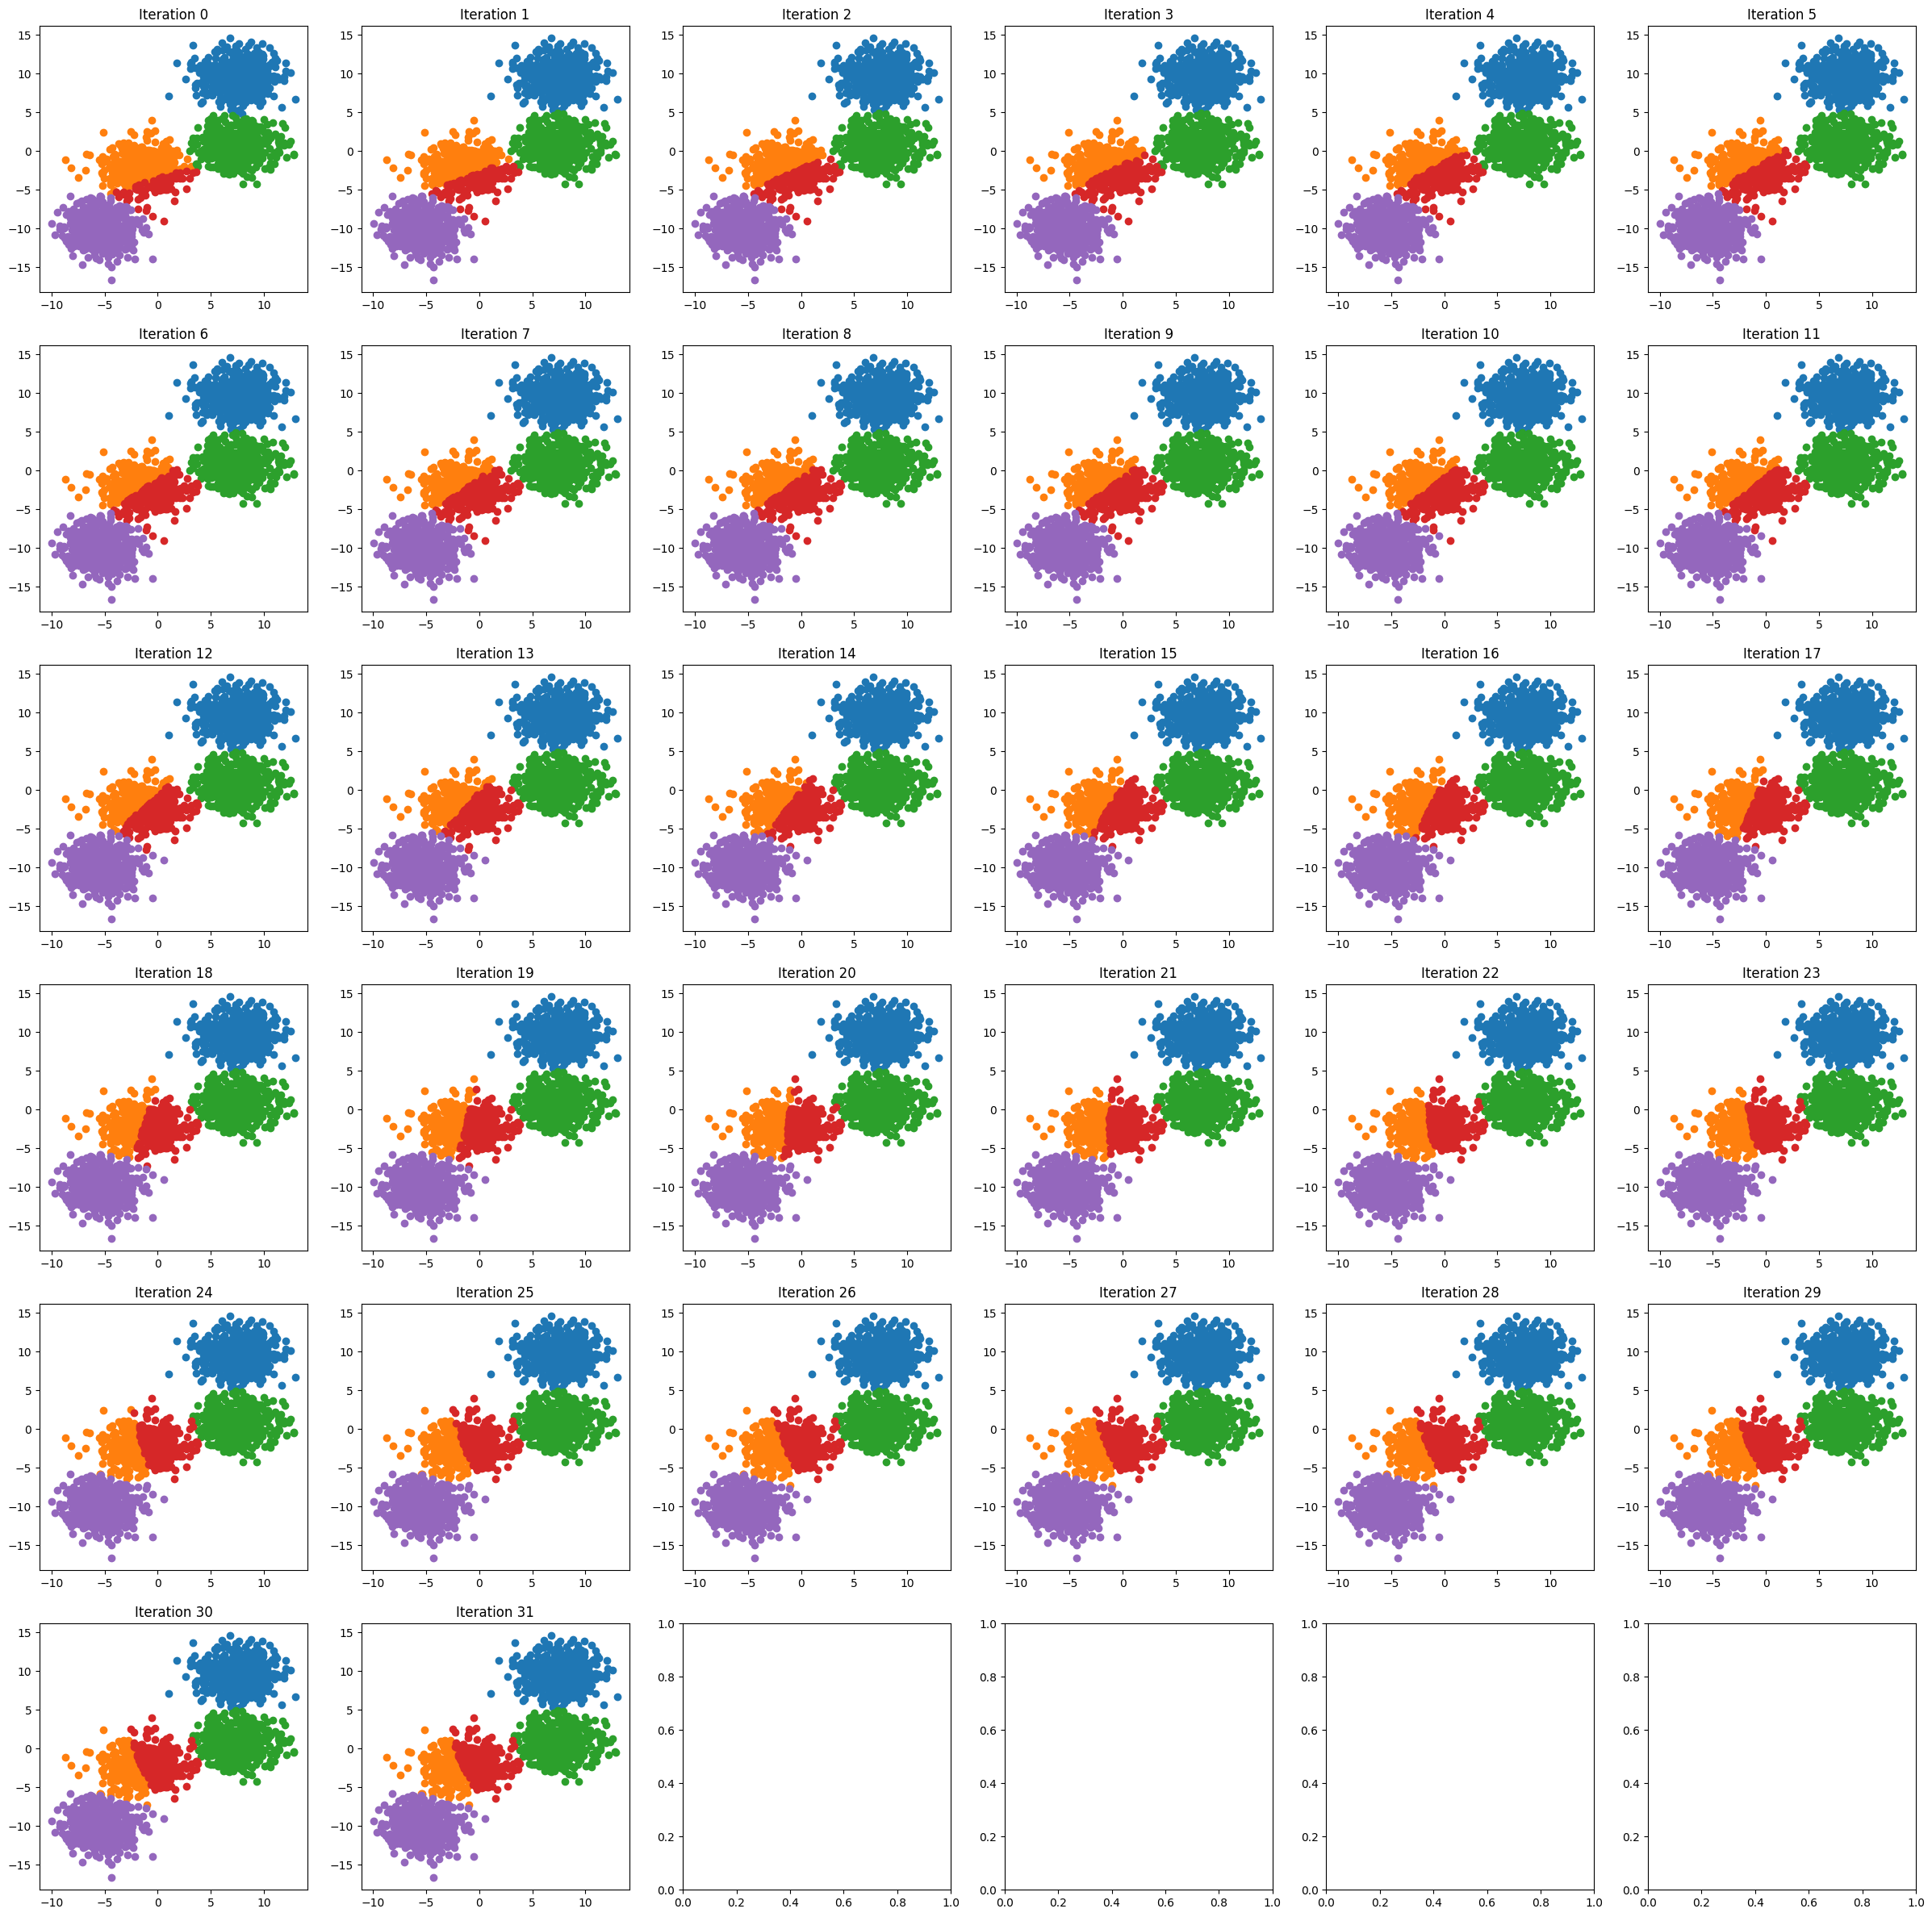

In [40]:
import math

def graphic_mosaic(model):

    rows = int(math.sqrt(len(model.memory)))
    fig, ax = plt.subplots(nrows=rows + 1, ncols=rows + 1,  figsize=(30,30))

    iter_cluster = enumerate(model.memory)
    for i in range(rows + 1):
        for j in range(rows + 1):
            try:
                index, (_, clusters) = next(iter_cluster)
            except StopIteration:
                break
            
            for col, cluster in enumerate(clusters):
                ax[i,j].scatter(
                    numpy_data[cluster,0], 
                    numpy_data[cluster,1], c=f'C0{col}'
                )
                ax[i,j].set_title(f'Iteration {index}')

    plt.show()

graphic_mosaic(model)

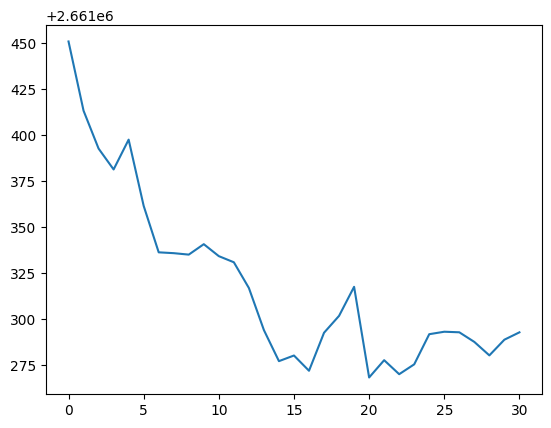

In [41]:
_ = plt.plot(range(len(model.inertia) - 1), model.inertia[1:])

In [42]:
import idx2numpy

file = './train-images.idx3-ubyte'
arr = idx2numpy.convert_from_file(file)
arrnew = np.array([arr_j.flatten() for arr_j in arr])


kmeans = KMeans(
    k=20, max_iters=1000
)
pred_y = kmeans.fit(arrnew)
# graphic_mosaic(kmeans)

Iteration 1 25336316.370
Iteration 2 939210942380.314
Iteration 3 939213374667.095
Iteration 4 939208632579.195
Iteration 5 939209402583.162
Iteration 6 939210619170.704
Iteration 7 939211477469.454
Iteration 8 939210958154.816
Iteration 9 939210266962.454
Iteration 10 939209389906.485
Iteration 11 939208894118.399
Iteration 12 939209512244.753
Iteration 13 939210047786.361
Iteration 14 939209898372.161
Iteration 15 939210006172.639
Iteration 16 939209653474.052
Iteration 17 939210230908.813
Iteration 18 939210421440.296
Iteration 19 939210511666.416
Iteration 20 939210814279.985
Iteration 21 939210870836.245
Iteration 22 939211342374.613
Iteration 23 939211274516.809
Iteration 24 939210965196.072
Iteration 25 939211079373.761
Iteration 26 939211142060.655
Iteration 27 939211006715.307
Iteration 28 939210969881.047
Iteration 29 939211257707.186
Iteration 30 939211110899.586
Iteration 31 939210948581.342
Iteration 32 939210989614.116
Iteration 33 939210891974.801
Iteration 34 9392107698

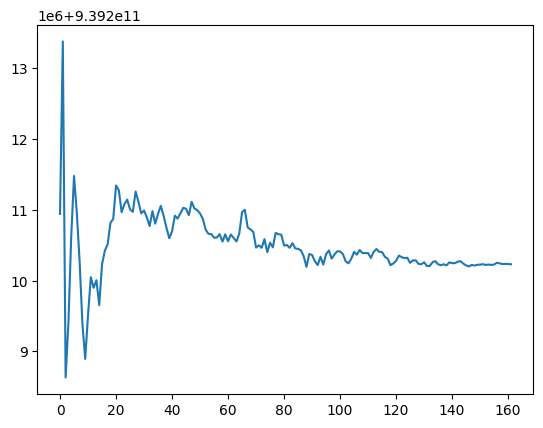

In [43]:
inertia_list = kmeans.inertia[1:]
_ = plt.plot(range(len(inertia_list)), inertia_list)

3. Considere una matriz de A $\in R^{m×n}$ con m > n y un vector b $\in R^m$. Buscamos el vector solución $x \in R^n$ del sistema lineal Ax = b. Describa como puede asegurar de forma práctica si la solución del sistema existe o no

`R\:` Podemos asegurar si existe una solución del sistema lineal Ax = b utilizando el teorema de rangos.

En primer lugar, podemos crear una matriz aumentada [A|b] que consiste en la matriz A combinada con el vector b como una columna adicional de la derecha.

Luego, podemos calcular el rango de la matriz A y también el rango de la matriz aumentada [A|b]. Si el rango de la matriz aumentada es mayor que el rango de la matriz A, entonces no hay solución única. Si el rango de ambas matrices es el mismo, entonces existe una solución única.

Si el rango de la matriz A es menor que el número de columnas, entonces existen infinitas soluciones. Podemos encontrar una solución particular utilizando cualquier método, como la eliminación gaussiana, y podemos encontrar el conjunto completo de soluciones a través de la ecuación homogénea Ax = 0.

En resumen, para asegurar si existe una solución única del sistema lineal Ax = b, podemos comparar el rango de la matriz A y la matriz aumentada [A|b]. Si el rango es igual, hay solución única y si el rango de la matriz aumentada [A|b] es mayor que el rango de la matriz A, entonces no existe solución única.

4. En este problema trataremos el problema de clasificación binaria, es decir, determinar si un dato pertenece a una de dos clases.

  - Programe el algoritmo del Perceptrón. Puede ser útil construir en este caso    una rutina 
    $$Perceptron_fit(X, y, nitmax, eta)$$ 
    que tome los datos X, sus etiquetas y, y que retorne los pesos w delclasificador. Otros hiperparámetros a considerar son nitmax y eta quecorresponden respectivamente al número máximo de iteraciones del algoritmo y ellearning rate.
  -  Programe una rutina que dado un vector de pesos w, y un conjunto de datos Xprediga en a que conjunto de datos pertenece cada dato.
  - Programe una rutina que dado un vector de pesos w, un conjunto de datos X ysus etiquetas y, entregue un score de que tan bien clasificados están los datossegún las predicciones hechas por el clasificador.
  - Use las bases de datos datos1.csv y datos2.csv, grafique los datosidentificando sus respectivas etiquetas y junto a ellos el resultado delhiperplano separador obtenido por su algoritmo de Perceptrón.
  - Cree 10 nuevos datos de la siguiente forma: 
  
    ```python    
    numpy.random.seed(18)
    new_data = numpy.random.random(size = (10, 2))
    new_data_labels = numpy.random.randint(2, size = 10)
    ```
    Para el primer set de datos, prediga la clase a la que pertenecen cada uno desus datos con la función de predicción creada y calcule el score. Grafíqueestos datos junto al conjunto inicial de datos y discuta la capacidadpredictora de este clasificador.

In [ ]:
import numpy as np

class Perceptron:
    def __init__(self, learning_rate=0.01, n_iter=1000):
        self.learning_rate = learning_rate
        self.n_iter = n_iter
    
    def _activation_function(self, X):
        return np.where(X >= 0, 1, -1)
    
    def fit(self, X, y):
        self.weights = np.zeros(1 + X.shape[1])
        self.errors = []
        for _ in range(self.n_iter):
            error = 0
            for xi, target in zip(X, y):
                update = self.learning_rate * (target - self._predict(xi))
                self.weights[1:] += update * xi
                self.weights[0] += update
                error += int(update != 0.0)
            self.errors.append(error)
        return self
    
    def _predict(self, X):
        return np.dot(X, self.weights[1:]) + self.weights[0]
    
    def predict(self, X):
        return self._activation_function(self._predict(X))

5. Muestre que para A $\in R^m$,n con valores singulares σ_1, ..., σ_p, p = mın{m, n}, su norma esta dada por
$$
||A||_F = \sqrt(σ^2_1, + ..., + σ^2_p)

6. Considere nuevamente la base de datos de imágenes de dígitos de MNIST.
  - a) Calcule la descomposicion en valores singular de la matriz de asociada a los datos utilizando la funcion svd de la librería numpy.linalg.
 - b) Utilice la SVD para reducir la dimensión de los datos a la mitad, es decir realice un analisis de componentes principales.
 - c) Grafique 10 imágenes y sus respectivas proyeccciones una vez realizado en el analisis de componentes principales.
 - d) Para los datos proyectado calcule nuevamente su algoritmo de clustering y compare con los resultados obtenidos en la pregunta 2.